In [12]:
from __future__ import print_function

import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Convolution1D, MaxPooling1D
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from six.moves import cPickle as pickle
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback

# fix random seed for reproducibility
seed=7
np.random.seed(seed)
import tensorflow as tf
tf.set_random_seed(seed)

NAME="LSTM-10.2"
split_valid_test=False

In [13]:
# Dane wejściowe
with open("X-sequences.pickle", 'rb') as f:
    X = pickle.load(f)
with open("Y.pickle", 'rb') as f:
    Y = pickle.load(f)
    

In [14]:
np.unique(Y)

array([  24,   37,  162,  231,  303,  325,  412,  573,  606,  665,  859,
        959, 1191, 1250, 1305, 1351, 1356, 1381, 1534, 1603, 1683, 1823,
       1833, 1903, 1983, 2153, 2183, 2234, 2344, 2584, 2655, 2687, 2694,
       2712, 2716, 2729, 2764, 2844, 2954, 4035, 4104, 4144, 4145, 4146])

W tej wersji eksperymentu, Y zawiera root_service - 44 unikalne kategorie główne. 
Zamieńmy je na liczby z przedziału 0-43

In [15]:
root_services=np.sort(np.unique(Y))
# skonstruuj odwrtotny indeks kategorii głównych
services_idx={root_services[i]: i for i in range(len(root_services))}

In [16]:
# Zamień 
Y=[services_idx[y] for y in Y]

In [17]:
Y=to_categorical(Y)
Y.shape

(22450, 44)

In [18]:
top_words = 5000
classes=Y[0,].shape[0]
print(classes)

44


In [19]:
# max_length (98th percentile is 476), padd the rest
max_length=500
X=sequence.pad_sequences(X, maxlen=max_length)


# slice in half even/odds to nulify time differencies
X_train=X[0:][::2] # even
X_test=X[1:][::2] # odds

Y_train=np.array(Y[0:][::2]) # even
Y_test=np.array(Y[1:][::2]) # odds

if split_valid_test:
    # Split "test" in half for validation and final testing
    X_valid=X_test[:len(X_test)/2]
    Y_valid=Y_test[:len(Y_test)/2]
    X_test=X_test[len(X_test)/2:]
    Y_test=Y_test[len(Y_test)/2:]
else:
    X_valid=X_test
    Y_valid=Y_test

In [20]:
# create the model
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# model.add(Convolution1D(nb_filter=1024, filter_length=3, border_mode='same', activation='relu'))
# model.add(MaxPooling1D(pool_length=2))
# model.add(Convolution1D(nb_filter=512, filter_length=3, border_mode='same', activation='relu'))
# model.add(MaxPooling1D(pool_length=2))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


# Callbacks
early_stop_cb = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

checkpoit_cb = ModelCheckpoint(NAME+".h5", save_best_only=True)

# Print the batch number at the beginning of every batch.
batch_print_cb = LambdaCallback(on_batch_begin=lambda batch, logs: print (".",end=''), 
                                on_epoch_end=lambda batch, logs: print (batch))

# Plot the loss after every epoch.
plot_loss_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: 
                              print (epoch, logs))
                              #plt.plot(np.arange(epoch), logs['loss']))

print("done")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          500000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 64)           19264     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 250, 16)           3088      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 125, 16)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               46800     
__________

In [21]:
history = model.fit(
        X,#_train,
        Y,#_train,
        initial_epoch=200,
        epochs=300,
        batch_size=1024,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.3,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )

#history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=3, batch_size=512)

................200
200 {'acc': 0.165075728657198, 'loss': 3.5458040180378658, 'val_acc': 0.13479810133753367, 'val_loss': 2.8823333771948012}
................201
201 {'acc': 0.17697594531873292, 'loss': 2.8055852585292826, 'val_acc': 0.20353325504163666, 'val_loss': 2.6592358840616184}
................202
202 {'acc': 0.25353188245475816, 'loss': 2.6303187277809541, 'val_acc': 0.33165083312365334, 'val_loss': 2.3802558871742665}
................203
203 {'acc': 0.35859742941588746, 'loss': 2.3059678528620511, 'val_acc': 0.34619952748903471, 'val_loss': 2.1538395213401231}
................204
204 {'acc': 0.38888888915819841, 'loss': 2.1314054335045181, 'val_acc': 0.38494655950052437, 'val_loss': 2.0882845434610182}
................205
205 {'acc': 0.43133511583253115, 'loss': 2.018911347401966, 'val_acc': 0.42102138064536232, 'val_loss': 1.9680861112907211}
................206
206 {'acc': 0.46639938880669884, 'loss': 1.8828499963208587, 'val_acc': 0.45917458467698719, 'val_loss': 1.855522

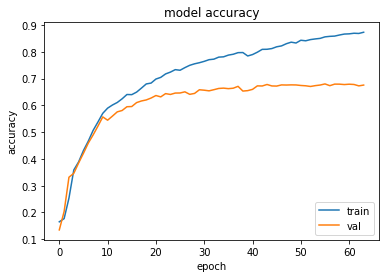

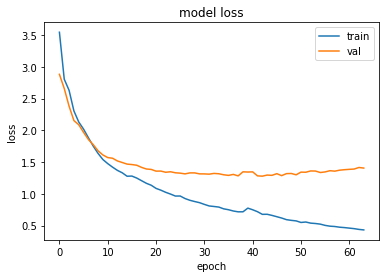

In [22]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
# plt.title('model loss (log scale)')
# plt.yscale('log')
plt.show()

In [25]:

history2 = model.fit(
        X,#_train,
        Y,#_train,
        initial_epoch=10000,    
        epochs=10050,
        batch_size=1024,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.3,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )    

................10000
10000 {'acc': 0.92064401264999063, 'loss': 0.26861639642694213, 'val_acc': 0.68497624929613854, 'val_loss': 1.5715816304123034}
................10001
10001 {'acc': 0.9205803749624123, 'loss': 0.26326394750217119, 'val_acc': 0.67933491856355277, 'val_loss': 1.5882249127657566}
................10002
10002 {'acc': 0.92427135141232364, 'loss': 0.26034148080864528, 'val_acc': 0.68007719601701389, 'val_loss': 1.637434688146777}
................10003
10003 {'acc': 0.92408043939648232, 'loss': 0.25239949219096658, 'val_acc': 0.6796318329428267, 'val_loss': 1.5912886883470621}
................10004
10004 {'acc': 0.9240804387668291, 'loss': 0.25327368379701287, 'val_acc': 0.68245249859227708, 'val_loss': 1.5947540831395963}
................10005
10005 {'acc': 0.92522591367635132, 'loss': 0.25923121294114099, 'val_acc': 0.68230404140264012, 'val_loss': 1.6093536255761733}
................10006
10006 {'acc': 0.92821687618496918, 'loss': 0.24091740912785434, 'val_acc': 0.67562

In [15]:
score=model.evaluate(X_test,Y_test, verbose=0)
print("OOS %s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("OOS %s: %.2f" % (model.metrics_names[0], score[0]))

NameError: name 'X_test' is not defined

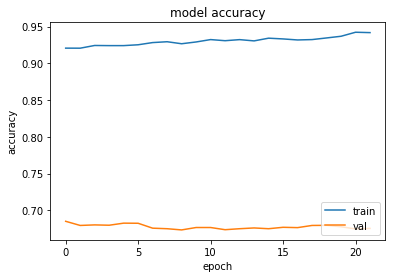

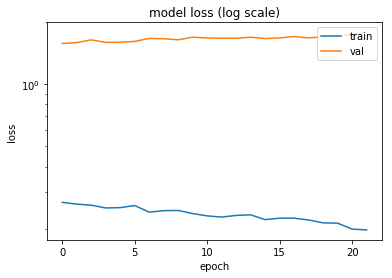

In [26]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.yscale('log')
plt.show()

In [15]:
history3 = model.fit(
        X,#_train,
        Y,#_train,
        initial_epoch=60,    
        epochs=90,
        batch_size=1024,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.3,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )

................60
60 {'acc': 0.69396716357036081, 'loss': 1.0682002606852541, 'val_acc': 0.61906176239181299, 'val_loss': 1.4453319599962575}
................61
61 {'acc': 0.7037037048871484, 'loss': 1.0332637657505632, 'val_acc': 0.61564727237275552, 'val_loss': 1.4414969362725554}
................62
62 {'acc': 0.70701285371711209, 'loss': 1.0041220267947522, 'val_acc': 0.62232779267281646, 'val_loss': 1.4268438312050282}
................63
63 {'acc': 0.71197658232548955, 'loss': 0.99611397675313584, 'val_acc': 0.62262470591946051, 'val_loss': 1.4255109716764256}
................64
64 {'acc': 0.71834033401439978, 'loss': 0.97293814648437305, 'val_acc': 0.62069477901889136, 'val_loss': 1.4260232516535671}
................65
65 {'acc': 0.72184039811467771, 'loss': 0.97190722480626812, 'val_acc': 0.61935867436424852, 'val_loss': 1.4186554088162131}
................66
66 {'acc': 0.72578592269766862, 'loss': 0.94906096593772571, 'val_acc': 0.62024940674208684, 'val_loss': 1.40941029149959

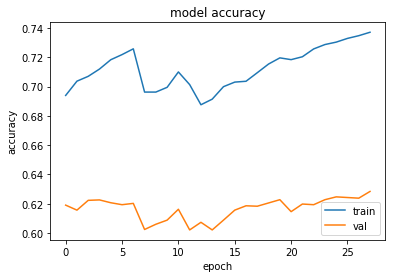

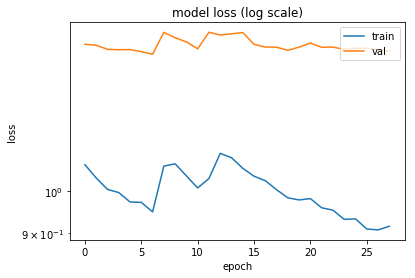

In [16]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.yscale('log')
plt.show()